## Notebook for testing models and extract feature importances.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score

In [2]:
# This path will be active after the launch of the hackathon
teamname = 'trachack-a-groups-admin-py-tracfone'
data_folder='s3://tf-trachack-data/212/'
# change root_folder to your team's root folder
# s3://tf-trachack-notebooks/<this should be replaced by team name as provided in EMAIL>/jupyter/jovyan/
root_folder='s3://tf-trachack-notebooks/trachack-project-groups-4-unavarra/jupyter/jovyan/'

In [3]:
def numerical_cleaner(df):
    
    df = df.select_dtypes(exclude=['datetime64','string','object'])

    skip_word = ["line_id","redemption_date","deactivation_date"]

    momentos_b1 = df.drop(columns=[col for col in df.columns if col in skip_word]).describe()

    # Hago transpuesta para poder utilizarlo como dataframe

    momentos_b1_T = momentos_b1.T

    # max_val =  momentos_b1_T["max"]
    # min_val = momentos_b1_T["min"]

    number_of_rows = momentos_b1_T.shape[0]

    index = momentos_b1_T.index

    # Creo las listas para encasillar las variables en estudio.

    variables_ruido = []
    
    # Para cada fila (variables columna que fueron puestas como filas) se analizara la columna max y min.
    # Para luego encasillar en las listas correspondientes.

    for i in range(0, number_of_rows):
        if momentos_b1_T["max"][i] == momentos_b1_T["min"][i]:
            variables_ruido.append(index[i])
        else:
            pass
        
    return sorted(set(variables_ruido))


def categorical_cleaner(df):
    
    df = df.select_dtypes(exclude=['float64','int64'])

    lista_columnas = []

    columnasdf = df.columns

    for i in range(len(columnasdf)):
        lista_columnas.append(columnasdf[i])

    index = df.index

    number_of_rows = len(index)

    # Calculo el porcentage de las 'entries' que son atribuidas a los diferentes valores en cada variable:

    variables_ruido = []
    
    lista_columnas.remove("line_id")

    for c in lista_columnas:

        if len(df[str(c)].value_counts()) == 0:

            variables_ruido.append(str(c))

        else:

            valores = (df[str(c)].value_counts() / number_of_rows) * 100
            # print(valores)

            for z in range(len(valores)):

                if valores[z] >= 95:

                    variables_ruido.append(str(c))

                else:
                    pass

    return variables_ruido


def total_creator(df,col1,col2):
    
    name_sep = str(col1.split('_')[0])
    
    name = name_sep + "_total"
    
    df[name] = abs(df[col1] - df[col2])
    
    return print("column_created")

def Other_label(df, col, n):
    # n is the number of biggest frequencies labels you want to keep
    
    biggest = df[col].value_counts().nlargest(n).index
    
    df[col] = np.where(df[col].isin(biggest), df[col], 'OTHER')
    
    return print("Done labeling with OTHER "+ str(col) + " column.")

def value_count_filter(df):
    
    col = df.columns.tolist()
    
    noise_list = []
    
    for i in col:
        
        if df[i].value_counts().nlargest(1)[0] > 6e6:
            
            noise_list.append(df[i].name)
            
        else:
            
            pass
    
    return noise_list

## 1. Upgrades

base dataset that has line_id, upgrade_date and upgrade columns.

### Variables

+ **line_id** = identificador único de número telefonico
+ **upgrade_date** = fecha del upgrade, si es que hay upgrade
+ **upgrade** = Target del estudio, realiza upgrade o no

In [4]:
upgrades=pd.read_csv(data_folder+"data/dev/upgrades.csv")
upgrades.head(2)

,line_id,date_observed,upgrade
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,2021-03-14,yes
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,2021-03-10,yes


In [5]:
upgrades["date_observed"] = pd.to_datetime(upgrades["date_observed"], format = '%Y-%m-%d')
upgrades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55868 entries, 0 to 55867
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   line_id        55868 non-null  object        
 1   date_observed  55868 non-null  datetime64[ns]
 2   upgrade        55868 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.3+ MB


## 2. Customer Info

customer info has carrier, plan and activation information for each line_id. One line_id in upgrades data has one and only record in customer info, hence you can do inner join on both.

+ **line_id** = identificador único de número telefonico
+ **carrier** = ni idea, pero es categorica y se divide en carrier 1, 2 y 3
+ **first_activation_date** = fecha de activación (de que? el número?)
+ **plan_name** = categórica, hay 4 planes o caen en Otro
+ **plan_subtype** = Smart o None, casi todos son None por lo que no aporta nada
+ **redemption_date** = Fecha de colección del pago? algo asi

In [6]:
customer_info = pd.read_csv(data_folder+"data/dev/customer_info.csv")
customer_info["first_activation_date"] = pd.to_datetime(customer_info["first_activation_date"], format = '%Y-%m-%d')
customer_info["redemption_date"] = pd.to_datetime(customer_info["redemption_date"], format = '%Y-%m-%d')
customer_info.drop('plan_subtype', axis='columns', inplace=True)

## 3. Phone Info

 phone info has all the device information for each line_id. One line_id in upgrades data has one and only record in phone info, hence inner join would be the right choice for both

In [7]:
# Read csv
phone_info=pd.read_csv(data_folder+"data/dev/phone_info.csv")

In [8]:
# Exploratory analysis of model released year

lista_modelos_sinFecha = phone_info.loc[phone_info["year_released"].isna()]["gsma_model_name"].value_counts().index.tolist()

phone_info.loc[phone_info["year_released"].isna()]["gsma_model_name"].value_counts().nlargest(10)

XT2005DL     2311
LG L722DL     941
SM-S111DL     889
SM-S102DL     875
XT2052-DL     833
LG L455DL     771
SM-S215DL     648
LG L125DL     427
SM-S205DL     401
Z723EL        349
Name: gsma_model_name, dtype: int64

In [9]:
moto_list = [x for x in lista_modelos_sinFecha if x.startswith('XT')]

lg_list = [x for x in lista_modelos_sinFecha if x.startswith('LG')]

sm_list = [x for x in lista_modelos_sinFecha if x.startswith('SM')]

for i in (moto_list + lg_list + sm_list):
    
    print(i)

XT2005DL
XT2052-DL
XT2041DL
XT2041-4
XT2045-3
XT2043-4
XT1952-4
XT2013-4
XT2052-1
XT2019-2
XT2005-5
XT2005-1PP
XT1962-6
XT2041-1
XT2015-2
XT2010-1
XT2027-1
XT1980-4
XT2055-2
XT1955-6
XT2005-1
XT2005-3
XT1952-6
XT2025-1
XT2041-6
LG L722DL
LG L455DL
LG L125DL
LG L555DL
LG442BG
SM-S111DL
SM-S102DL
SM-S215DL
SM-S205DL
SM-S115DL
SM-S506DL
SM-G981U1
SM-A515F/DS
SM-A505U1
SM-A715F/DS
SM-G986U1
SM-G988U1
SM-A207M/DS
SM-G986U
SM-A015A
SM-A102U1
SM-A205U1
SM-G985F/DS
SM-A515U
SM-A115M/DS
SM-G981U
SM-A215U
SM-G988U
SM-A015T1
SM-G988B/DS
SM-G715U1
SM-A015M/DS


In [10]:
# For later imputation

def Updated_year_released(df, list_2019, list_2020, others):
    
    for i in range(len(df)):
        
        if pd.isna(df["gsma_operating_system"][i]):
            
            df.loc[i,"gsma_operating_system"] = "Android"
            
        else:
            
            pass
        
        if df["gsma_model_name"][i] in list_2019:
            
            df.loc[i,"year_released"] = 2019
            
        elif df["gsma_model_name"][i] in list_2020:
            
            df.loc[i,"year_released"] = 2020
            
        elif df["gsma_model_name"][i] in others:
            
            df.loc[i, "year_released"] = 2017
            
        else:
            
            pass
        
    return df

motorola_2019 = list(set(["XT2005-1","XT2005-3","XT2005DL","XT2029","XT2029-1","XT2025-2","XT1952-4",
                 "XT1952-6","XT2013","XT1955-6","XT1962-6","XT1980-4","XT2005-1PP",
                "XT2010-1","XT2013-4","XT2015-2","XT2019-2","XT2025-1"]))

motorola_2020 = list(set(["XT2053-2","XT2052-1", "XT2052-2", "XT2052-2PP", "XT2052-5", "XT2052-6", "XT2052-DL",
                "XT2041-4", "XT2041-6", "XT2041-7", "XT2041-DL","XT2045-3","XT2043","XT2043-4","XT2043-7",
                "XT2055-2","XT2027-1","XT2041-1","XT2041-4","XT2041-6","XT2041DL","XT2043-4","XT2045-3"]))

listed_2017 = ["LG442BG","SM-S115DL","Z723EL"]

lg_2019 = ["LG L722DL"]

lg_2020 = ["LG L455DL","LG L125DL","LG L555DL"]

sm_2019 = ["SM-A015M/DS","SM-A015T1","SM-S111DL","SM-A015A","SM-S506DL","SM-A102U1","SM-A205U1","SM-A207M/DS",
          "SM-A505U1","SM-A515F/DS","SM-A515U","SM-S102DL","SM-S205DL"]

sm_2020 = ["SM-G981U","SM-G981U1","SM-G985F/DS","SM-G986U","SM-G986U1","SM-G988B/DS","SM-G988U","SM-G988U1",
          "SM-G715U1","SM-A715F/DS","SM-A115M/DS","SM-A215U","SM-A715F/DS","SM-G715U1","SM-S215DL"]

model_2019 = motorola_2019 + lg_2019 + sm_2019

model_2020 = motorola_2020 + lg_2020 + sm_2020

# Matching models with their released year, which were searched in web pages.

phone_info = Updated_year_released(phone_info, model_2019, model_2020, listed_2017)

# Finald phone_info df

phone_info = phone_info[['line_id','gsma_operating_system','total_ram','touch_screen','wi_fi','year_released']]

replace_zero = ["touch_screen","wi_fi"]

for i in replace_zero:
    
    phone_info[i] = phone_info[i].fillna(0)
    
phone_info["year_released"] = phone_info["year_released"].astype(pd.Int64Dtype(), errors = "ignore").fillna(2018).astype(int)

phone_info[["wi_fi","touch_screen"]] = phone_info[["wi_fi","touch_screen"]].astype(pd.Int64Dtype(), errors = "ignore").astype(int)

phone_info.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55868 entries, 0 to 55867
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   line_id                55868 non-null  object
 1   gsma_operating_system  55868 non-null  object
 2   total_ram              33632 non-null  object
 3   touch_screen           55868 non-null  int64 
 4   wi_fi                  55868 non-null  int64 
 5   year_released          55868 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 2.6+ MB


In [11]:
# Merging 

df_1to3 = upgrades.merge(customer_info, on = 'line_id', how = 'inner')
df_1to3 = df_1to3.merge(phone_info, on = 'line_id', how = 'inner')

In [12]:
# Updating "upgrade" values.

df_1to3['upgrade'].replace({'yes':1,'no':0}, inplace=True)

In [13]:
df_1to3["total_ram"].value_counts()

2048               18966
3072                6236
4096                3401
1024                2140
6144                 870
1536                 637
512                  450
8192                 228
6144/8192            200
5632                 167
3072/4096             59
12288                 55
8                     43
4096/6144             42
5415                  34
256                   31
7680                  16
2048/3072             15
2560                  12
1096/6144              6
4096/6144/8192         5
32                     3
6144/8192/12288        2
768                    2
8192/12288             2
2048/4096              2
128                    2
1843                   2
3072/4096/6144         2
1024/2048              1
4                      1
Name: total_ram, dtype: int64

In [14]:
# Labeling categories

Other_label(df_1to3, "total_ram", 7)
Other_label(df_1to3, "carrier", 1)
Other_label(df_1to3, "plan_name", 3)
Other_label(df_1to3, "gsma_operating_system",2)

Done labeling with OTHER total_ram column.
Done labeling with OTHER carrier column.
Done labeling with OTHER plan_name column.
Done labeling with OTHER gsma_operating_system column.


In [15]:
# Days from activation_date to observed_date (to give us an idea of how old the client is) 
# And redemption_date to observed_date (to give us an idea of how old the client current plan is)

df_1to3["activation_to_observed"] = (df_1to3["date_observed"] - df_1to3["first_activation_date"]).dt.days.astype(float, errors = 'ignore')
df_1to3["redemption_to_observed"] = (df_1to3["date_observed"] - df_1to3["redemption_date"]).dt.days.astype(float, errors = 'ignore')


In [16]:
# And (date_observed - year_released) to give us an idea of which clients tend to improve their model more often.

df_1to3["released_to_observed"] = (df_1to3["date_observed"].dt.year - df_1to3["year_released"]).astype(int, errors = 'ignore')


upgrade
0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

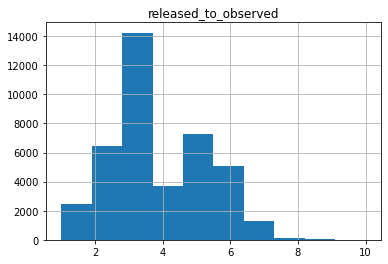

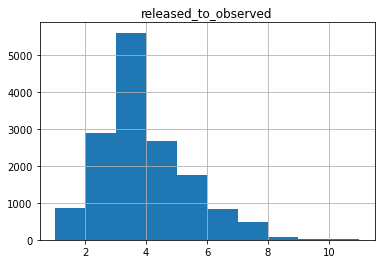

In [17]:
# Released to observed hist

df_1to3[["released_to_observed","upgrade"]].groupby("upgrade").hist()

<AxesSubplot:xlabel='upgrade', ylabel='released_to_observed'>

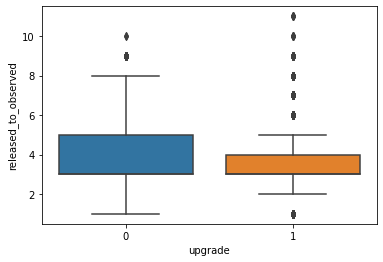

In [18]:
# Released to observed boxplot

sns.boxplot(x="upgrade", y="released_to_observed", data=df_1to3)

<AxesSubplot:xlabel='upgrade', ylabel='redemption_to_observed'>

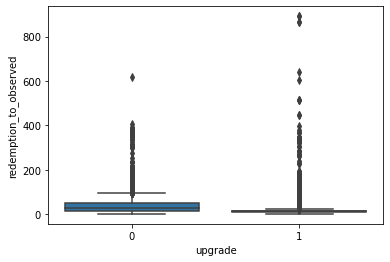

In [19]:
# Take it off as it doesn't represent clear differences

sns.boxplot(x="upgrade", y="redemption_to_observed", data=df_1to3)

<AxesSubplot:xlabel='upgrade', ylabel='activation_to_observed'>

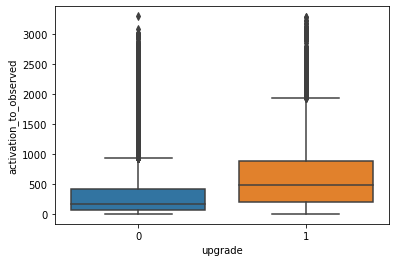

In [20]:
# Activation to observed boxplot

sns.boxplot(x="upgrade", y="activation_to_observed", data=df_1to3)

<AxesSubplot:xlabel='activation_to_observed', ylabel='Count'>

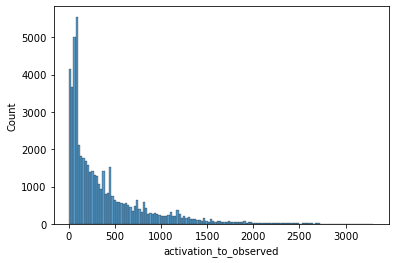

In [21]:
sns.histplot(x="activation_to_observed", data=df_1to3)

<AxesSubplot:xlabel='redemption_to_observed', ylabel='Count'>

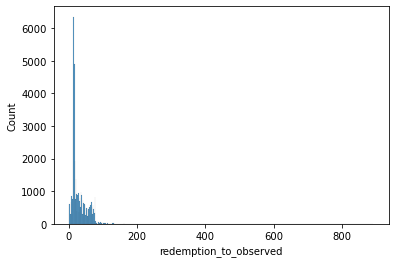

In [22]:
sns.histplot(x="redemption_to_observed", data=df_1to3)

upgrade
0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

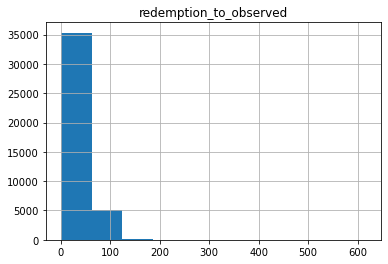

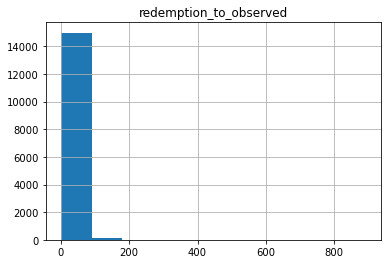

In [23]:
df_1to3["redemption_to_observed"] = df_1to3["redemption_to_observed"].fillna(df_1to3["redemption_to_observed"].median())

df_1to3[["redemption_to_observed","upgrade"]].groupby("upgrade").hist()

In [24]:
df_1to3.drop(["first_activation_date","redemption_date"], axis=1, inplace = True)
df_1to3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55868 entries, 0 to 55867
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   line_id                 55868 non-null  object        
 1   date_observed           55868 non-null  datetime64[ns]
 2   upgrade                 55868 non-null  int64         
 3   carrier                 55868 non-null  object        
 4   plan_name               55868 non-null  object        
 5   gsma_operating_system   55868 non-null  object        
 6   total_ram               55868 non-null  object        
 7   touch_screen            55868 non-null  int64         
 8   wi_fi                   55868 non-null  int64         
 9   year_released           55868 non-null  int64         
 10  activation_to_observed  55147 non-null  float64       
 11  redemption_to_observed  55868 non-null  float64       
 12  released_to_observed    55868 non-null  int64 

In [25]:
df_1to3["activation_to_observed"] = df_1to3["activation_to_observed"].fillna(df_1to3["activation_to_observed"].median()) 

In [26]:
df_1to3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55868 entries, 0 to 55867
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   line_id                 55868 non-null  object        
 1   date_observed           55868 non-null  datetime64[ns]
 2   upgrade                 55868 non-null  int64         
 3   carrier                 55868 non-null  object        
 4   plan_name               55868 non-null  object        
 5   gsma_operating_system   55868 non-null  object        
 6   total_ram               55868 non-null  object        
 7   touch_screen            55868 non-null  int64         
 8   wi_fi                   55868 non-null  int64         
 9   year_released           55868 non-null  int64         
 10  activation_to_observed  55868 non-null  float64       
 11  redemption_to_observed  55868 non-null  float64       
 12  released_to_observed    55868 non-null  int64 

# 4. Redemptions

In [27]:
# Reading of csv

redemptions=pd.read_csv(data_folder+"data/dev/redemptions.csv")

In [28]:
redemptions.drop(categorical_cleaner(redemptions), axis = 1, inplace = True)

In [29]:
#Agrupado por line_id para tener una fila por cliente
a = redemptions.groupby(['line_id']).nunique("line_id")
a = a["redemption_date"]

#Promedio de revenue generado por cliente
b = redemptions.groupby(["line_id"]).mean()

#Merge de ambos
redemptions = pd.merge(a, b, on = "line_id", how = "inner").reset_index()

#Df limpio
redemptions.columns = ["line_id", "redemption_count", "mean_revenue"]

# 5. Deactivations

In [30]:
# Reading of csv
deactivations=pd.read_csv(data_folder+"data/dev/deactivations.csv")

# Droping categorical noise

deactivations.drop(categorical_cleaner(deactivations), axis = 1, inplace = True)

In [31]:
# Featuring deactivations 

deactivations = deactivations.groupby("line_id").count().reset_index()
deactivations = deactivations[["line_id", "deactivation_date"]]
deactivations.columns = ["line_id", "deactivations_count"]
deactivations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44757 entries, 0 to 44756
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   line_id              44757 non-null  object
 1   deactivations_count  44757 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 699.5+ KB


# 6. Suspensions

In [32]:
# Cleaning and featuring

suspensions=pd.read_csv(data_folder+"data/dev/suspensions.csv")

suspensions = suspensions.astype({"suspension_start_date": 'datetime64[ns]', "suspension_end_date": 'datetime64[ns]'})

suspensions["days_suspended"] = (suspensions["suspension_end_date"] - 
                                 suspensions["suspension_start_date"]).dt.days.astype(float, errors = 'ignore').fillna(0)

suspensions["days_suspended"] = suspensions["days_suspended"].astype(int)

suspensions.drop(["suspension_start_date","suspension_end_date"], axis = "columns", inplace = True)

#Agrupado por line_id para tener una fila por cliente
z = suspensions.groupby(['line_id']).nunique("line_id")
z = z["days_suspended"]

#Promedio de revenue generado por cliente
y = suspensions.groupby(["line_id"]).mean()

#Merge de ambos
suspensions = pd.merge(z, y, on = "line_id", how = "inner").reset_index()

#Df limpio
suspensions.columns = ["line_id", "suspension_count", "mean_suspension_days"]

# 7. Network usage domestic

In [33]:
network_usage_domestic=pd.read_csv(data_folder+"data/dev/network_usage_domestic.csv")

network_usage_domestic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6381966 entries, 0 to 6381965
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   line_id            object 
 1   date               object 
 2   hotspot_kb         float64
 3   kb_5g              float64
 4   mms_in             int64  
 5   mms_out            int64  
 6   sms_in             int64  
 7   sms_out            int64  
 8   total_kb           float64
 9   voice_count_in     int64  
 10  voice_count_total  int64  
 11  voice_min_in       int64  
 12  voice_min_out      int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 633.0+ MB


In [34]:
# Cleaning and featuring

network_usage_domestic["date"] = pd.to_datetime(network_usage_domestic["date"], format = '%Y-%m-%d')

for i in network_usage_domestic.columns.tolist():
    
    # creating bool series True for NaN values 
    bool_series = pd.isnull(network_usage_domestic[i]) 

    # filtering data
    print(network_usage_domestic[bool_series]) 

Empty DataFrame
Columns: [line_id, date, hotspot_kb, kb_5g, mms_in, mms_out, sms_in, sms_out, total_kb, voice_count_in, voice_count_total, voice_min_in, voice_min_out]
Index: []
Empty DataFrame
Columns: [line_id, date, hotspot_kb, kb_5g, mms_in, mms_out, sms_in, sms_out, total_kb, voice_count_in, voice_count_total, voice_min_in, voice_min_out]
Index: []
Empty DataFrame
Columns: [line_id, date, hotspot_kb, kb_5g, mms_in, mms_out, sms_in, sms_out, total_kb, voice_count_in, voice_count_total, voice_min_in, voice_min_out]
Index: []
Empty DataFrame
Columns: [line_id, date, hotspot_kb, kb_5g, mms_in, mms_out, sms_in, sms_out, total_kb, voice_count_in, voice_count_total, voice_min_in, voice_min_out]
Index: []
Empty DataFrame
Columns: [line_id, date, hotspot_kb, kb_5g, mms_in, mms_out, sms_in, sms_out, total_kb, voice_count_in, voice_count_total, voice_min_in, voice_min_out]
Index: []
Empty DataFrame
Columns: [line_id, date, hotspot_kb, kb_5g, mms_in, mms_out, sms_in, sms_out, total_kb, voice_

# 8. LRP Points


In [35]:
# Reading csv

lrp_points=pd.read_csv(data_folder+"data/dev/lrp_points.csv")

lrp_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8860 entries, 0 to 8859
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   line_id         8860 non-null   object 
 1   quantity        8859 non-null   float64
 2   status          8860 non-null   object 
 3   total_quantity  8859 non-null   float64
 4   update_date     8860 non-null   object 
dtypes: float64(2), object(3)
memory usage: 346.2+ KB


In [36]:
# Cleaning

lrp_points["update_date"] = pd.to_datetime(lrp_points["update_date"], format = '%Y-%m-%d')

# creating bool series True for NaN values 
bool_series = pd.isnull(lrp_points["quantity"]) 
    
# filtering data
lrp_points[bool_series] 


,line_id,quantity,status,total_quantity,update_date
1029,6b14e3db-483f-44ea-ab28-80f1473576c4,NaN,ENROLLED,NaN,2021-01-25


In [37]:
values = {'quantity': 0, 'total_quantity': 0}

lrp_points = lrp_points.fillna(value=values)

lrp_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8860 entries, 0 to 8859
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   line_id         8860 non-null   object        
 1   quantity        8860 non-null   float64       
 2   status          8860 non-null   object        
 3   total_quantity  8860 non-null   float64       
 4   update_date     8860 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 346.2+ KB


# 9. LRP Enrollment

In [38]:
lrp_enrollment=pd.read_csv(data_folder+"data/dev/lrp_enrollment.csv")

lrp_enrollment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17634 entries, 0 to 17633
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   line_id              17634 non-null  object
 1   lrp_enrolled         17634 non-null  object
 2   lrp_enrollment_date  17634 non-null  object
dtypes: object(3)
memory usage: 413.4+ KB


In [39]:
lrp_enrollment["lrp_enrollment_date"] = pd.to_datetime(lrp_enrollment["lrp_enrollment_date"], format = '%Y-%m-%d')

In [40]:
lrp_enrollment['lrp_enrolled'].replace({'Y':1}, inplace=True)

In [41]:
# network_usage_domestic noise

net_numeric = numerical_cleaner(network_usage_domestic)

# lrp_points noise

lrp_pNumeric = numerical_cleaner(lrp_points)

lrp_pCat = categorical_cleaner(lrp_points)

# lrp_enrollment noise

lrp_enCat = categorical_cleaner(lrp_enrollment)

In [42]:
def flattenList(nested_list):
    results = []
    for i in nested_list:
        if isinstance(i, list):
            results.extend(i)
            results = flattenList(results)
        else:
            results.append(i)
    return results

noise = flattenList(net_numeric + lrp_pNumeric + lrp_pCat + lrp_enCat)

noise

['status']

In [43]:
count_noise = value_count_filter(network_usage_domestic)

network_usage_domestic.drop(count_noise, axis='columns', inplace=True)

network_usage_mean = network_usage_domestic.groupby("line_id").mean().reset_index()

# Creating totals

total_creator(network_usage_mean,"voice_min_in","voice_min_out")
total_creator(network_usage_mean,"sms_in","sms_out")
total_creator(network_usage_mean,"mms_in","mms_out")

# Droping previous columns no longer necessary

network_usage_mean.drop(["voice_min_in","voice_min_out","voice_count_in","mms_in","mms_out","sms_in","sms_out"], axis='columns', inplace=True)

# Final df

network_usage_domestic = network_usage_mean[["line_id","voice_count_total","sms_total","total_kb"]]


column_created
column_created
column_created


In [44]:
df_7to9 = pd.merge(network_usage_domestic, lrp_points[["line_id","total_quantity"]], on = "line_id", how = 'left')

df_7to9 = pd.merge(df_7to9, lrp_enrollment[["line_id","lrp_enrolled"]], on = "line_id", how = 'left')

df_7to9["lrp_enrolled"] = df_7to9["lrp_enrolled"].fillna(0)  

In [45]:
df_7to9["total_quantity"] = df_7to9["total_quantity"].fillna(0)

In [46]:
df_7to9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55126 entries, 0 to 55125
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   line_id            55126 non-null  object 
 1   voice_count_total  55126 non-null  float64
 2   sms_total          55126 non-null  float64
 3   total_kb           55126 non-null  float64
 4   total_quantity     55126 non-null  float64
 5   lrp_enrolled       55126 non-null  float64
dtypes: float64(5), object(1)
memory usage: 2.9+ MB


# JOINS

In [47]:
df = pd.merge(df_1to3, redemptions, on = "line_id", how = "left")

df = pd.merge(df, deactivations, on = "line_id", how = "left")

df = pd.merge(df, suspensions, on = "line_id", how = "left")

df = pd.merge(df, df_7to9, on = "line_id", how = "left")

df = df.drop_duplicates(subset=['line_id'])



In [297]:
df.drop("date_observed", axis = 1, inplace = True)

df.drop("mean_revenue", axis = 1, inplace = True)

df.drop("year_released", axis = 1, inplace = True)

df.drop("wi_fi", axis = 1, inplace = True)

df.drop("line_id", axis = 1, inplace = True)

df.drop("gsma_operating_system", axis = 1, inplace = True)

df.drop("total_ram", axis = 1, inplace = True)

df.drop("carrier", axis = 1, inplace = True)

df.drop("sms_total", axis = 1, inplace = True)

df.drop("touch_screen", axis = 1, inplace = True)

In [54]:
X_reduce.drop("date_observed", axis = 1, inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [55]:
X_reduce.head()

,upgrade,carrier,plan_name,gsma_operating_system,total_ram,touch_screen,wi_fi,year_released,activation_to_observed,redemption_to_observed,...,redemption_count,mean_revenue,deactivations_count,suspension_count,mean_suspension_days,voice_count_total,sms_total,total_kb,total_quantity,lrp_enrolled
1,1,carrier 1,OTHER,iOS,3072,1,1,2018,699.0,20.0,...,25.0,50.728800,3.0,1.0,1.000000,3.461111,0.233333,5.256640e+05,0.0,1.0
2,0,carrier 1,OTHER,iOS,2048,1,1,2016,175.0,20.0,...,6.0,35.000000,4.0,4.0,11.666667,1.763314,0.301775,1.990593e+05,0.0,0.0
4,1,carrier 1,OTHER,Android,6144,1,1,2018,191.0,20.0,...,6.0,54.000000,1.0,2.0,1.125000,6.061111,2.900000,1.023210e+06,0.0,0.0
5,0,OTHER,plan 1,Android,OTHER,0,0,2018,65.0,25.0,...,3.0,20.000000,1.0,2.0,13.428571,15.615385,1.200000,3.190443e+05,0.0,0.0
6,0,OTHER,plan 1,iOS,2048,1,1,2016,206.0,84.0,...,9.0,21.913333,2.0,3.0,23.000000,21.392405,1.234177,2.175507e+05,0.0,0.0


In [178]:
# X will carry out the variables and y will be the target

y = df["upgrade"].copy()

df.drop("upgrade", axis = 1, inplace = True)

X = df


In [179]:
X.head()

,plan_name,activation_to_observed,redemption_to_observed,released_to_observed,redemption_count,deactivations_count,suspension_count,mean_suspension_days,voice_count_total,total_kb,total_quantity,lrp_enrolled
0,OTHER,951.0,20.0,4,31.0,NaN,3.0,12.000000,0.222222,2.871749e+05,0.0,1.0
1,OTHER,699.0,20.0,3,25.0,3.0,1.0,1.000000,3.461111,5.256640e+05,0.0,1.0
2,OTHER,175.0,20.0,5,6.0,4.0,4.0,11.666667,1.763314,1.990593e+05,0.0,0.0
3,plan 1,44.0,15.0,5,2.0,NaN,NaN,NaN,3.159091,2.412951e+05,0.0,0.0
4,OTHER,191.0,20.0,3,6.0,1.0,2.0,1.125000,6.061111,1.023210e+06,0.0,0.0


In [180]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55868 entries, 0 to 55875
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   plan_name               55868 non-null  object 
 1   activation_to_observed  55868 non-null  float64
 2   redemption_to_observed  55868 non-null  float64
 3   released_to_observed    55868 non-null  int64  
 4   redemption_count        54885 non-null  float64
 5   deactivations_count     44757 non-null  float64
 6   suspension_count        48539 non-null  float64
 7   mean_suspension_days    48539 non-null  float64
 8   voice_count_total       55118 non-null  float64
 9   total_kb                55118 non-null  float64
 10  total_quantity          55118 non-null  float64
 11  lrp_enrolled            55118 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 5.5+ MB


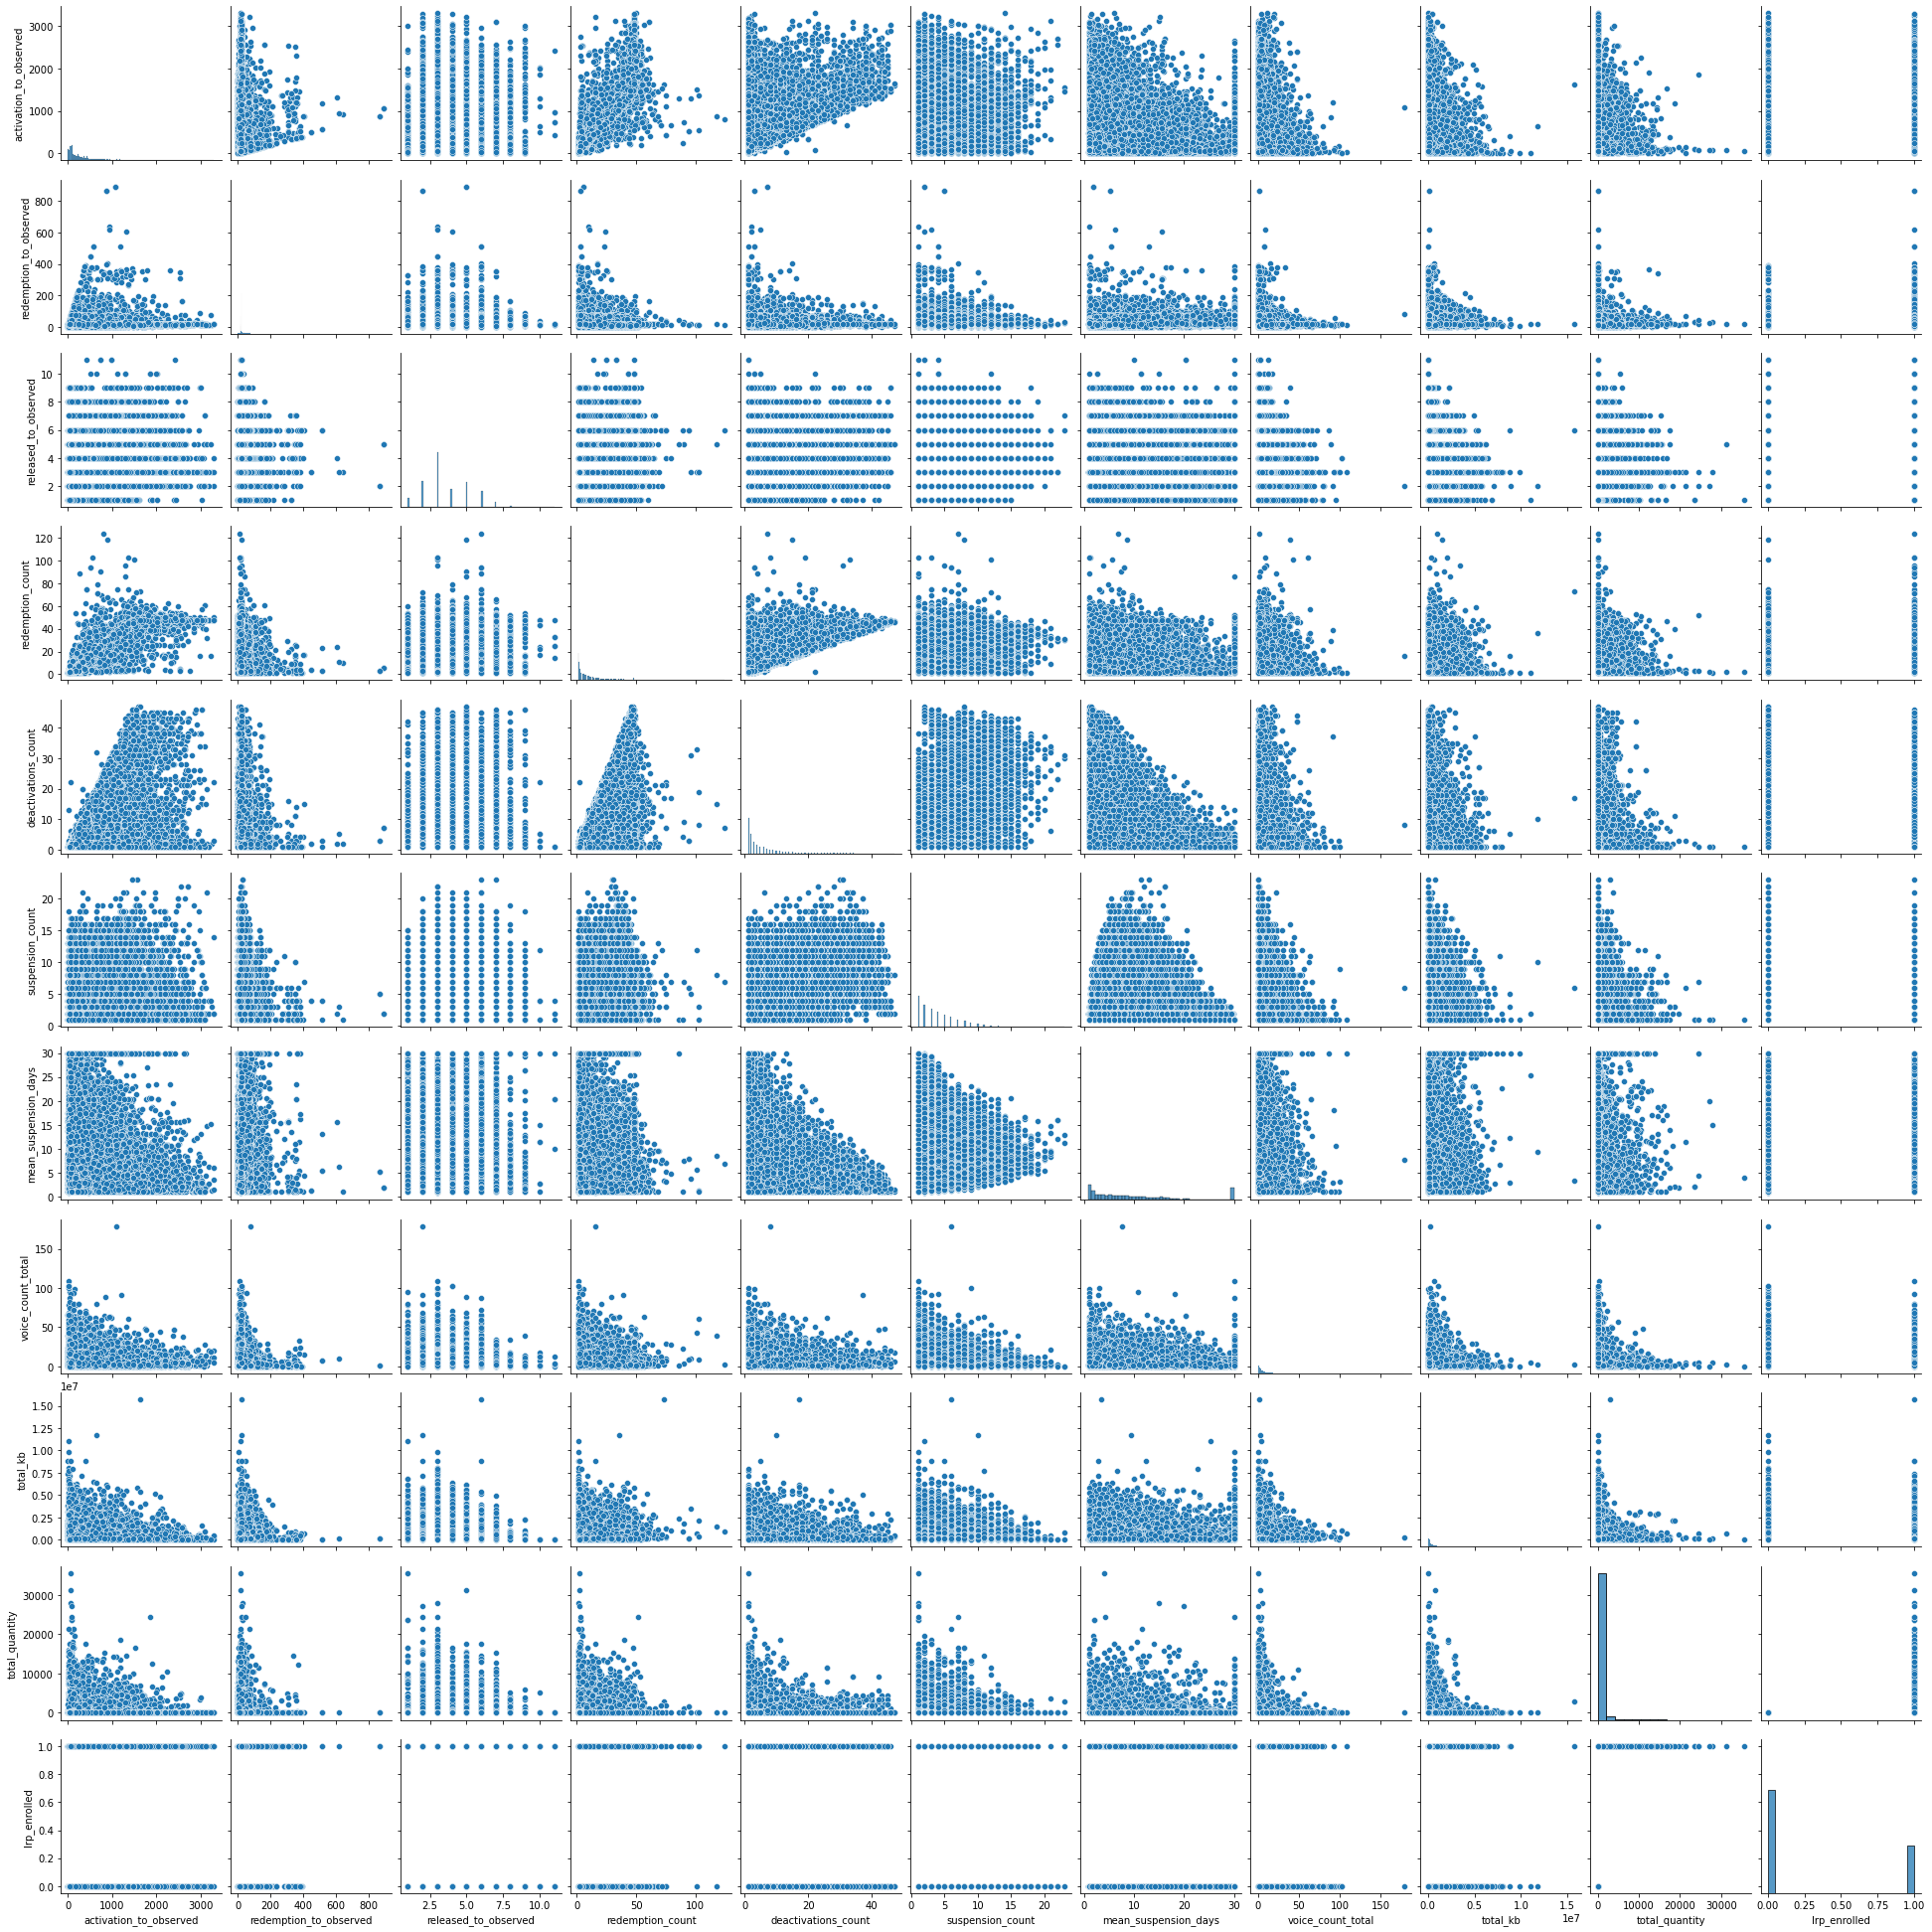

In [181]:
sns.pairplot(X.iloc[:,1:])

In [182]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55868 entries, 0 to 55875
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   plan_name               55868 non-null  object 
 1   activation_to_observed  55868 non-null  float64
 2   redemption_to_observed  55868 non-null  float64
 3   released_to_observed    55868 non-null  int64  
 4   redemption_count        54885 non-null  float64
 5   deactivations_count     44757 non-null  float64
 6   suspension_count        48539 non-null  float64
 7   mean_suspension_days    48539 non-null  float64
 8   voice_count_total       55118 non-null  float64
 9   total_kb                55118 non-null  float64
 10  total_quantity          55118 non-null  float64
 11  lrp_enrolled            55118 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 5.5+ MB


In [183]:
X_reduce = df.dropna()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 42825 entries, 1 to 55875
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   plan_name               42825 non-null  object 
 1   activation_to_observed  42825 non-null  float64
 2   redemption_to_observed  42825 non-null  float64
 3   released_to_observed    42825 non-null  int64  
 4   redemption_count        42825 non-null  float64
 5   deactivations_count     42825 non-null  float64
 6   suspension_count        42825 non-null  float64
 7   mean_suspension_days    42825 non-null  float64
 8   voice_count_total       42825 non-null  float64
 9   total_kb                42825 non-null  float64
 10  total_quantity          42825 non-null  float64
 11  lrp_enrolled            42825 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 4.2+ MB


In [184]:
X["lrp_enrolled"] = X["lrp_enrolled"].fillna(0)

X["total_quantity"] = X["total_quantity"].fillna(0)

#X["sms_total"] = X["sms_total"].fillna(X["sms_total"].median())

X["total_kb"] = X["total_kb"].fillna(X["total_kb"].median())

X["voice_count_total"] = X["voice_count_total"].fillna(X["voice_count_total"].median())

X["redemption_count"] = X["redemption_count"].fillna(X["redemption_count"].median())

X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 55868 entries, 0 to 55875
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   plan_name               55868 non-null  object 
 1   activation_to_observed  55868 non-null  float64
 2   redemption_to_observed  55868 non-null  float64
 3   released_to_observed    55868 non-null  int64  
 4   redemption_count        55868 non-null  float64
 5   deactivations_count     44757 non-null  float64
 6   suspension_count        48539 non-null  float64
 7   mean_suspension_days    48539 non-null  float64
 8   voice_count_total       55868 non-null  float64
 9   total_kb                55868 non-null  float64
 10  total_quantity          55868 non-null  float64
 11  lrp_enrolled            55868 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 5.5+ MB


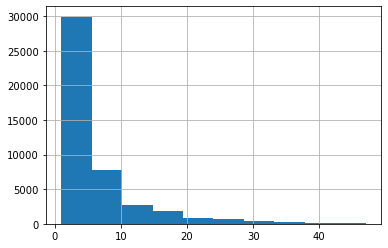

In [185]:
X["deactivations_count"].hist()

X["deactivations_count"] = X["deactivations_count"].fillna(X["deactivations_count"].median())

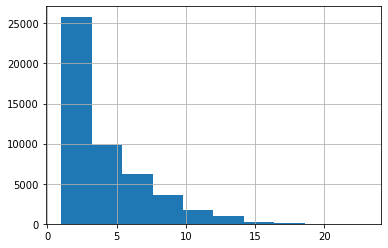

In [186]:
X["suspension_count"].hist()

X["suspension_count"] = X["suspension_count"].fillna(X["suspension_count"].median())

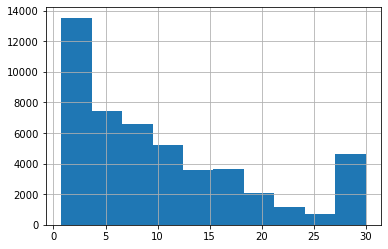

In [187]:
X["mean_suspension_days"].hist()

X["mean_suspension_days"] = X["mean_suspension_days"].fillna(X["mean_suspension_days"].median())

In [188]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55868 entries, 0 to 55875
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   plan_name               55868 non-null  object 
 1   activation_to_observed  55868 non-null  float64
 2   redemption_to_observed  55868 non-null  float64
 3   released_to_observed    55868 non-null  int64  
 4   redemption_count        55868 non-null  float64
 5   deactivations_count     55868 non-null  float64
 6   suspension_count        55868 non-null  float64
 7   mean_suspension_days    55868 non-null  float64
 8   voice_count_total       55868 non-null  float64
 9   total_kb                55868 non-null  float64
 10  total_quantity          55868 non-null  float64
 11  lrp_enrolled            55868 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 5.5+ MB


In [57]:
X_reduce_encoded = pd.get_dummies(X_reduce, columns = object_list)
X_reduce_encoded.head()

,upgrade,touch_screen,wi_fi,year_released,activation_to_observed,redemption_to_observed,released_to_observed,redemption_count,mean_revenue,deactivations_count,...,gsma_operating_system_OTHER,gsma_operating_system_iOS,total_ram_1024,total_ram_1536,total_ram_2048,total_ram_3072,total_ram_4096,total_ram_512,total_ram_6144,total_ram_OTHER
1,1,1,1,2018,699.0,20.0,3,25.0,50.728800,3.0,...,0,1,0,0,0,1,0,0,0,0
2,0,1,1,2016,175.0,20.0,5,6.0,35.000000,4.0,...,0,1,0,0,1,0,0,0,0,0
4,1,1,1,2018,191.0,20.0,3,6.0,54.000000,1.0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,2018,65.0,25.0,3,3.0,20.000000,1.0,...,0,0,0,0,0,0,0,0,0,1
6,0,1,1,2016,206.0,84.0,5,9.0,21.913333,2.0,...,0,1,0,0,1,0,0,0,0,0


In [128]:
X_encoded.head()

,activation_to_observed,redemption_to_observed,released_to_observed,redemption_count,deactivations_count,suspension_count,mean_suspension_days,voice_count_total,total_kb,total_quantity,lrp_enrolled,plan_name_OTHER,plan_name_plan 1,plan_name_plan 2,plan_name_plan 3
0,951.0,20.0,4,31.0,3.0,3.0,12.000000,0.222222,2.871749e+05,0.0,1.0,1,0,0,0
1,699.0,20.0,3,25.0,3.0,1.0,1.000000,3.461111,5.256640e+05,0.0,1.0,1,0,0,0
2,175.0,20.0,5,6.0,4.0,4.0,11.666667,1.763314,1.990593e+05,0.0,0.0,1,0,0,0
3,44.0,15.0,5,2.0,3.0,3.0,8.000000,3.159091,2.412951e+05,0.0,0.0,0,1,0,0
4,191.0,20.0,3,6.0,1.0,2.0,1.125000,6.061111,1.023210e+06,0.0,0.0,1,0,0,0


In [59]:
def summary_PCA(df):
    
    scaler = StandardScaler()
    scaler.fit(df)
    df_scaled = scaler.transform(df)

    pca = PCA()

    pca.fit(df_scaled)

    pca_data = pca.transform(df_scaled)
    
    plt.figure(figsize=(20,10))
    
    print(np.round(pca.explained_variance_ratio_ * 100, decimals=1))

    per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
    labels = ['PC' +str(x) for x in range(1, len(per_var)+1)]
    plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label = labels)
    plt.ylabel('Percentage of explained variance')
    plt.xlabel('Principal Component')
    plt.title('Scree Plot')
    plt.show()
    
    def biplot(Z, components, pca_index_1, pca_index_2, labels, target):
        
        xc = Z[:, pca_index_1]
        yc = Z[:, pca_index_2]
        n = Z.shape[1]

        indices = [pca_index_1, pca_index_2]
        coeff = components[indices].T
        
        plt.figure(figsize=(20,10))

        plt.scatter(xc, yc, target, alpha=0.5)

        for i in range(n):
            plt.arrow(0, 0, coeff[i, 0] * 2, coeff[i, 1] * 2, color='r', width=0.02, head_width=0.1)
            plt.text(coeff[i,0] * 2.5, coeff[i,1] * 2.5, labels[i], color='k', ha='center', va='center')    

        plt.xlim(-4, 4)
        plt.ylim(-3, 3)
        plt.xlabel("PC{}".format(pca_index_1+1))
        plt.ylabel("PC{}".format(pca_index_2+1))
        plt.grid()
        
    biplot(pca_data, pca.components_, 0, 1, labels, y)
        
    return print("Done PCA")

[20.6 12.3 10.1  9.5  9.3  7.6  6.4  6.2  5.9  4.7  4.4  2.5  0.4  0. ]


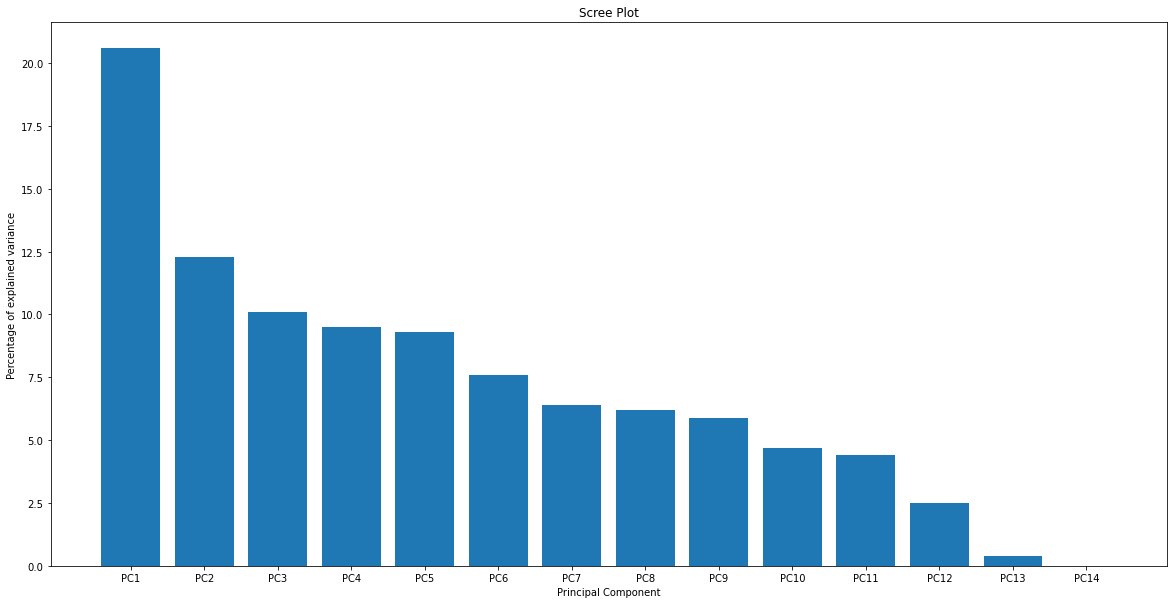

Done PCA


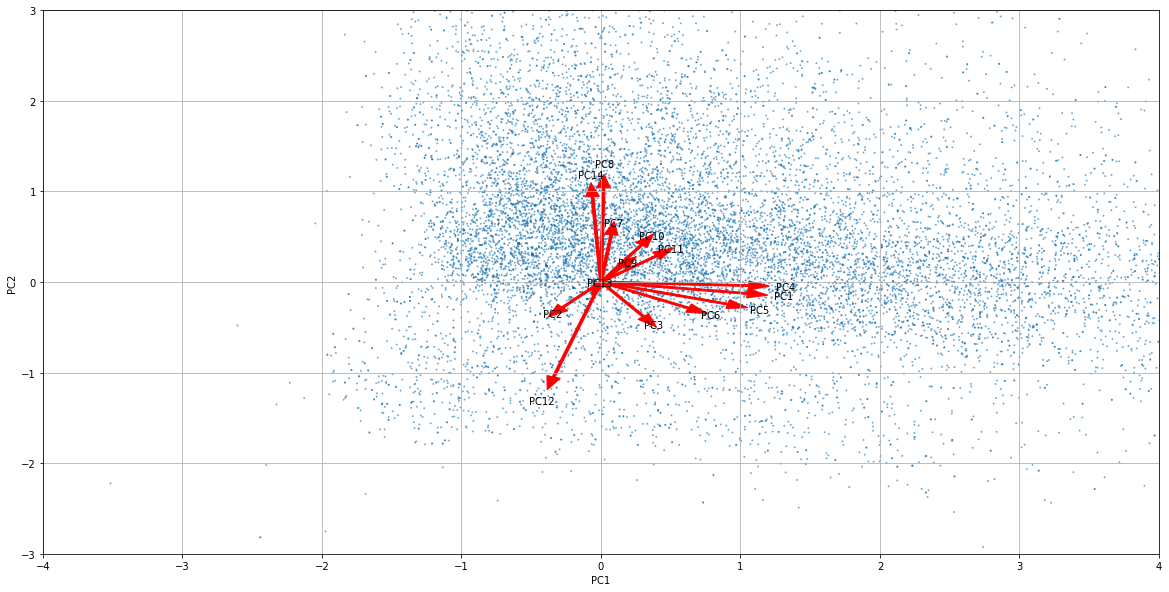

In [60]:
X1 = X_encoded.copy()

X1.drop("mean_suspension_days", axis = 1, inplace = True)

summary_PCA(X1)

In [ ]:
X2 = X_encoded.copy()

X2 = X2.iloc[:,:11] 

X2.drop("mean_suspension_days", axis = 1, inplace = True)

summary_PCA(X2)

In [ ]:
X3 = X_encoded.copy()

X3.drop(["mean_suspension_days","plan_name_plan 3","plan_name_plan 2"], axis = 1, inplace = True)

summary_PCA(X3)

## Random Forest

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
# Random Forest

def model_rf(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state = 12)

    scaler = StandardScaler()

    scaler.fit(X_train)

    scaler.fit(X_test)

    X_train_scaled = scaler.transform(X_train)

    X_test_scaled = scaler.transform(X_test)

    print(X_train_scaled.shape)

    print(X_test_scaled.shape)
    
    rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_features = 5, criterion = 'entropy')

    rf.fit(X_train_scaled, y_train)
    
    plot_confusion_matrix(rf,
                     X_test_scaled,
                     y_test,
                     display_labels = ["Did not upgrade","Upgraded"])
    
    y_pred=rf.predict(X_test_scaled)
    
    f1 = f1_score(y_test, y_pred)
    
    return print("Your f1 score is {}".format(f1))
    

In [76]:
def pca_to_rf(X, y, n):

    scaler = StandardScaler()

    scaler.fit(X)

    X_scaled = scaler.transform(X)

    pca = PCA(n_components = n)

    pca.fit(X_scaled)

    pca_X = pca.transform(X_scaled)

    return model_rf(pca_X, y)

(34260, 27)
(8565, 27)
Your f1 score is 0.8848991637973439


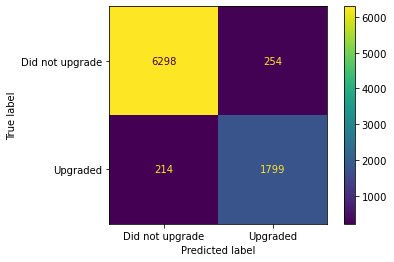

In [77]:
model_rf(X_reduce_encoded, y_reduce)

(44694, 15)
(11174, 15)
Your f1 score is 0.8894285251740327


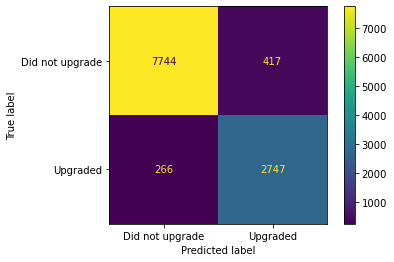

In [66]:
model_rf(X_encoded,y)

In [68]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


In [69]:
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size = 0.80, random_state = 12)

    scaler = StandardScaler()

    scaler.fit(X_train)

    scaler.fit(X_test)

    X_train_scaled = scaler.transform(X_train)

    X_test_scaled = scaler.transform(X_test)

    print(X_train_scaled.shape)

    print(X_test_scaled.shape)

(44694, 15)
(11174, 15)


In [70]:

def acc_model(params):
    clf = RandomForestClassifier(**params)
    clf.fit(X_train_scaled, y_train)
    y_pred=clf.predict(X_test_scaled)   
    f1 = f1_score(y_test, y_pred)
    return f1

param_space = {
    'max_features': hp.choice('max_features', range(3,9,1)),
    'n_estimators': hp.choice('n_estimators', range(900,1200,100)),
    'criterion': hp.choice('criterion', ["entropy"])}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

new best:                                              
0.8884210526315789                                     
{'criterion': 'entropy', 'max_features': 6, 'n_estimators': 1000}
new best:                                                                            
0.8887086307592473                                                                   
{'criterion': 'entropy', 'max_features': 3, 'n_estimators': 1000}                    
new best:                                                                            
0.890941500567169                                                                    
{'criterion': 'entropy', 'max_features': 6, 'n_estimators': 1100}                    
new best:                                                                            
0.890941500567169                                                                   
{'criterion': 'entropy', 'max_features': 5, 'n_estimators': 1100}                   
new best:                                         

{'criterion': 'entropy', 'max_features': 3, 'n_estimators': 900}                        
new best:                                                                               
0.8910121457489879                                                                      
{'criterion': 'entropy', 'max_features': 6, 'n_estimators': 1100}                       
new best:                                                                               
0.8910121457489879                                                                      
{'criterion': 'entropy', 'max_features': 4, 'n_estimators': 1000}                       
new best:                                                                               
0.8910121457489879                                                                      
{'criterion': 'entropy', 'max_features': 8, 'n_estimators': 1100}                       
new best:                                                                               
0.8910121457489879   

## XGBoost

In [89]:
import xgboost as xgb
from xgboost import XGBClassifier

In [121]:
def model_xgb(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state = 12)

    scaler = StandardScaler()

    scaler.fit(X_train)

    scaler.fit(X_test)

    X_train_scaled = scaler.transform(X_train)

    X_test_scaled = scaler.transform(X_test)

    print(X_train_scaled.shape)

    print(X_test_scaled.shape)
    
    xg = xgb.XGBClassifier(n_estimators = 100, objetcive='binary:logistic', missing=None, seed=12)
    
    def xgb_f1(y, t, threshold=0.5):
        t = t.get_label()
        y_bin = (y > threshold).astype(int) # works for both type(y) == <class 'numpy.ndarray'> and type(y) == <class 'pandas.core.series.Series'>
        return 'f1',f1_score(t,y_bin)
    
    
    xg.fit(X_train_scaled,
           y_train,
          early_stopping_rounds = 120,
          eval_set = [(X_test_scaled, y_test)],
           eval_metric=xgb_f1)


In [122]:
model_xgb(X_encoded, y)

(44694, 15)
(11174, 15)
[16:21:10] WARNING: ../src/learner.cc:573: 
Parameters: { "objetcive" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:21:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.51112	validation_0-f1:0.30334
[1]	validation_0-logloss:0.41094	validation_0-f1:0.70759
[2]	validation_0-logloss:0.34848	validation_0-f1:0.72072


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-logloss:0.30372	validation_0-f1:0.75861
[4]	validation_0-logloss:0.27492	validation_0-f1:0.76556
[5]	validation_0-logloss:0.25413	validation_0-f1:0.79425
[6]	validation_0-logloss:0.23817	validation_0-f1:0.80596
[7]	validation_0-logloss:0.22740	validation_0-f1:0.81135
[8]	validation_0-logloss:0.21932	validation_0-f1:0.81293
[9]	validation_0-logloss:0.21243	validation_0-f1:0.83102
[10]	validation_0-logloss:0.20693	validation_0-f1:0.83493
[11]	validation_0-logloss:0.20295	validation_0-f1:0.83585
[12]	validation_0-logloss:0.19951	validation_0-f1:0.83876
[13]	validation_0-logloss:0.19715	validation_0-f1:0.83978
[14]	validation_0-logloss:0.19546	validation_0-f1:0.84117
[15]	validation_0-logloss:0.19390	validation_0-f1:0.84349
[16]	validation_0-logloss:0.19201	validation_0-f1:0.84484
[17]	validation_0-logloss:0.19098	validation_0-f1:0.84445
[18]	validation_0-logloss:0.18949	validation_0-f1:0.84332
[19]	validation_0-logloss:0.18825	validation_0-f1:0.84509
[20]	validation_0-log

[144]	validation_0-logloss:0.17309	validation_0-f1:0.85700
[145]	validation_0-logloss:0.17315	validation_0-f1:0.85753
[146]	validation_0-logloss:0.17314	validation_0-f1:0.85724
[147]	validation_0-logloss:0.17301	validation_0-f1:0.85802
[148]	validation_0-logloss:0.17312	validation_0-f1:0.85840
[149]	validation_0-logloss:0.17296	validation_0-f1:0.85836
[150]	validation_0-logloss:0.17266	validation_0-f1:0.85928
[151]	validation_0-logloss:0.17251	validation_0-f1:0.85957
[152]	validation_0-logloss:0.17256	validation_0-f1:0.85976
[153]	validation_0-logloss:0.17255	validation_0-f1:0.85996
[154]	validation_0-logloss:0.17269	validation_0-f1:0.86000
[155]	validation_0-logloss:0.17263	validation_0-f1:0.86039
[156]	validation_0-logloss:0.17255	validation_0-f1:0.86019
[157]	validation_0-logloss:0.17245	validation_0-f1:0.86053
[158]	validation_0-logloss:0.17237	validation_0-f1:0.86092
[159]	validation_0-logloss:0.17227	validation_0-f1:0.86140
[160]	validation_0-logloss:0.17208	validation_0-f1:0.861

[283]	validation_0-logloss:0.17295	validation_0-f1:0.85949
[284]	validation_0-logloss:0.17295	validation_0-f1:0.86454
[285]	validation_0-logloss:0.17292	validation_0-f1:0.86521
[286]	validation_0-logloss:0.17309	validation_0-f1:0.86492
[287]	validation_0-logloss:0.17294	validation_0-f1:0.86091
[288]	validation_0-logloss:0.17291	validation_0-f1:0.86116
[289]	validation_0-logloss:0.17294	validation_0-f1:0.86101
[290]	validation_0-logloss:0.17293	validation_0-f1:0.86077
[291]	validation_0-logloss:0.17295	validation_0-f1:0.86052
[292]	validation_0-logloss:0.17291	validation_0-f1:0.86106
[293]	validation_0-logloss:0.17310	validation_0-f1:0.86067
[294]	validation_0-logloss:0.17330	validation_0-f1:0.86086
[295]	validation_0-logloss:0.17325	validation_0-f1:0.86067
[296]	validation_0-logloss:0.17327	validation_0-f1:0.86052
[297]	validation_0-logloss:0.17328	validation_0-f1:0.86047
[298]	validation_0-logloss:0.17335	validation_0-f1:0.86037
[299]	validation_0-logloss:0.17317	validation_0-f1:0.860

[422]	validation_0-logloss:0.17548	validation_0-f1:0.86683
[423]	validation_0-logloss:0.17551	validation_0-f1:0.86683
[424]	validation_0-logloss:0.17558	validation_0-f1:0.86639
[425]	validation_0-logloss:0.17556	validation_0-f1:0.86601
[426]	validation_0-logloss:0.17556	validation_0-f1:0.86586
[427]	validation_0-logloss:0.17552	validation_0-f1:0.86561
[428]	validation_0-logloss:0.17556	validation_0-f1:0.86576
[429]	validation_0-logloss:0.17557	validation_0-f1:0.86527
[430]	validation_0-logloss:0.17559	validation_0-f1:0.86522
[431]	validation_0-logloss:0.17558	validation_0-f1:0.86561
[432]	validation_0-logloss:0.17555	validation_0-f1:0.86561
[433]	validation_0-logloss:0.17561	validation_0-f1:0.86566
[434]	validation_0-logloss:0.17572	validation_0-f1:0.86614
[435]	validation_0-logloss:0.17569	validation_0-f1:0.86672
[436]	validation_0-logloss:0.17578	validation_0-f1:0.86672
[437]	validation_0-logloss:0.17583	validation_0-f1:0.86658
[438]	validation_0-logloss:0.17584	validation_0-f1:0.866

[561]	validation_0-logloss:0.18130	validation_0-f1:0.86564
[562]	validation_0-logloss:0.18128	validation_0-f1:0.86568
[563]	validation_0-logloss:0.18122	validation_0-f1:0.86578
[564]	validation_0-logloss:0.18131	validation_0-f1:0.86578
[565]	validation_0-logloss:0.18136	validation_0-f1:0.86578
[566]	validation_0-logloss:0.18147	validation_0-f1:0.86544
[567]	validation_0-logloss:0.18147	validation_0-f1:0.86583
[568]	validation_0-logloss:0.18160	validation_0-f1:0.86568
[569]	validation_0-logloss:0.18170	validation_0-f1:0.86554
[570]	validation_0-logloss:0.18177	validation_0-f1:0.86568
[571]	validation_0-logloss:0.18183	validation_0-f1:0.86544
[572]	validation_0-logloss:0.18181	validation_0-f1:0.86564
[573]	validation_0-logloss:0.18185	validation_0-f1:0.86617
[574]	validation_0-logloss:0.18185	validation_0-f1:0.86636
[575]	validation_0-logloss:0.18207	validation_0-f1:0.86564
[576]	validation_0-logloss:0.18204	validation_0-f1:0.86587
[577]	validation_0-logloss:0.18197	validation_0-f1:0.865

[700]	validation_0-logloss:0.18691	validation_0-f1:0.86815
[701]	validation_0-logloss:0.18690	validation_0-f1:0.86826
[702]	validation_0-logloss:0.18700	validation_0-f1:0.86849
[703]	validation_0-logloss:0.18705	validation_0-f1:0.86879
[704]	validation_0-logloss:0.18721	validation_0-f1:0.86912
[705]	validation_0-logloss:0.18710	validation_0-f1:0.86912
[706]	validation_0-logloss:0.18716	validation_0-f1:0.86951
[707]	validation_0-logloss:0.18718	validation_0-f1:0.86989
[708]	validation_0-logloss:0.18718	validation_0-f1:0.86970
[709]	validation_0-logloss:0.18719	validation_0-f1:0.86970
[710]	validation_0-logloss:0.18719	validation_0-f1:0.86970
[711]	validation_0-logloss:0.18728	validation_0-f1:0.86951
[712]	validation_0-logloss:0.18723	validation_0-f1:0.86965
[713]	validation_0-logloss:0.18724	validation_0-f1:0.86980
[714]	validation_0-logloss:0.18715	validation_0-f1:0.86908
[715]	validation_0-logloss:0.18725	validation_0-f1:0.86927
[716]	validation_0-logloss:0.18716	validation_0-f1:0.869

[839]	validation_0-logloss:0.19332	validation_0-f1:0.86839
[840]	validation_0-logloss:0.19354	validation_0-f1:0.86886
[841]	validation_0-logloss:0.19351	validation_0-f1:0.86901
[842]	validation_0-logloss:0.19354	validation_0-f1:0.86920
[843]	validation_0-logloss:0.19356	validation_0-f1:0.86964
[844]	validation_0-logloss:0.19364	validation_0-f1:0.86964
[845]	validation_0-logloss:0.19365	validation_0-f1:0.86926
[846]	validation_0-logloss:0.19368	validation_0-f1:0.86949
[847]	validation_0-logloss:0.19368	validation_0-f1:0.86920
[848]	validation_0-logloss:0.19367	validation_0-f1:0.86924
[849]	validation_0-logloss:0.19376	validation_0-f1:0.86939
[850]	validation_0-logloss:0.19387	validation_0-f1:0.86905
[851]	validation_0-logloss:0.19390	validation_0-f1:0.86891
[852]	validation_0-logloss:0.19392	validation_0-f1:0.86871
[853]	validation_0-logloss:0.19402	validation_0-f1:0.86852
[854]	validation_0-logloss:0.19417	validation_0-f1:0.86799
[855]	validation_0-logloss:0.19433	validation_0-f1:0.867

[978]	validation_0-logloss:0.19988	validation_0-f1:0.86901
[979]	validation_0-logloss:0.20002	validation_0-f1:0.86896
[980]	validation_0-logloss:0.20001	validation_0-f1:0.86882
[981]	validation_0-logloss:0.20009	validation_0-f1:0.86862
[982]	validation_0-logloss:0.20013	validation_0-f1:0.86882
[983]	validation_0-logloss:0.20033	validation_0-f1:0.86882
[984]	validation_0-logloss:0.20035	validation_0-f1:0.86896
[985]	validation_0-logloss:0.20042	validation_0-f1:0.86882
[986]	validation_0-logloss:0.20040	validation_0-f1:0.86843
[987]	validation_0-logloss:0.20040	validation_0-f1:0.86843
[988]	validation_0-logloss:0.20043	validation_0-f1:0.86843
[989]	validation_0-logloss:0.20049	validation_0-f1:0.86858
[990]	validation_0-logloss:0.20049	validation_0-f1:0.86873
[991]	validation_0-logloss:0.20041	validation_0-f1:0.86868
[992]	validation_0-logloss:0.20046	validation_0-f1:0.86883
[993]	validation_0-logloss:0.20053	validation_0-f1:0.86868
[994]	validation_0-logloss:0.20057	validation_0-f1:0.868

[1115]	validation_0-logloss:0.20613	validation_0-f1:0.86971
[1116]	validation_0-logloss:0.20609	validation_0-f1:0.87034
[1117]	validation_0-logloss:0.20616	validation_0-f1:0.87005
[1118]	validation_0-logloss:0.20616	validation_0-f1:0.87001
[1119]	validation_0-logloss:0.20629	validation_0-f1:0.87020
[1120]	validation_0-logloss:0.20632	validation_0-f1:0.87005
[1121]	validation_0-logloss:0.20631	validation_0-f1:0.87005
[1122]	validation_0-logloss:0.20645	validation_0-f1:0.86933
[1123]	validation_0-logloss:0.20647	validation_0-f1:0.86952
[1124]	validation_0-logloss:0.20658	validation_0-f1:0.86952
[1125]	validation_0-logloss:0.20663	validation_0-f1:0.86918
[1126]	validation_0-logloss:0.20681	validation_0-f1:0.86938
[1127]	validation_0-logloss:0.20681	validation_0-f1:0.86952
[1128]	validation_0-logloss:0.20678	validation_0-f1:0.86933
[1129]	validation_0-logloss:0.20688	validation_0-f1:0.86952
[1130]	validation_0-logloss:0.20688	validation_0-f1:0.87024
[1131]	validation_0-logloss:0.20693	vali

[1252]	validation_0-logloss:0.21253	validation_0-f1:0.87077
[1253]	validation_0-logloss:0.21257	validation_0-f1:0.87058
[1254]	validation_0-logloss:0.21268	validation_0-f1:0.87077
[1255]	validation_0-logloss:0.21273	validation_0-f1:0.87077
[1256]	validation_0-logloss:0.21273	validation_0-f1:0.87091
[1257]	validation_0-logloss:0.21283	validation_0-f1:0.87091
[1258]	validation_0-logloss:0.21283	validation_0-f1:0.87091
[1259]	validation_0-logloss:0.21296	validation_0-f1:0.87091
[1260]	validation_0-logloss:0.21305	validation_0-f1:0.87024
[1261]	validation_0-logloss:0.21310	validation_0-f1:0.87001
[1262]	validation_0-logloss:0.21312	validation_0-f1:0.87058
[1263]	validation_0-logloss:0.21319	validation_0-f1:0.87072
[1264]	validation_0-logloss:0.21324	validation_0-f1:0.87058
[1265]	validation_0-logloss:0.21327	validation_0-f1:0.87058
[1266]	validation_0-logloss:0.21338	validation_0-f1:0.87043
[1267]	validation_0-logloss:0.21337	validation_0-f1:0.87043
[1268]	validation_0-logloss:0.21339	vali

[1389]	validation_0-logloss:0.21763	validation_0-f1:0.87066
[1390]	validation_0-logloss:0.21770	validation_0-f1:0.87104
[1391]	validation_0-logloss:0.21766	validation_0-f1:0.87157
[1392]	validation_0-logloss:0.21773	validation_0-f1:0.87172
[1393]	validation_0-logloss:0.21778	validation_0-f1:0.87115
[1394]	validation_0-logloss:0.21779	validation_0-f1:0.87100
[1395]	validation_0-logloss:0.21778	validation_0-f1:0.87081
[1396]	validation_0-logloss:0.21782	validation_0-f1:0.87119
[1397]	validation_0-logloss:0.21780	validation_0-f1:0.87119
[1398]	validation_0-logloss:0.21784	validation_0-f1:0.87138
[1399]	validation_0-logloss:0.21784	validation_0-f1:0.87138
[1400]	validation_0-logloss:0.21785	validation_0-f1:0.87138
[1401]	validation_0-logloss:0.21793	validation_0-f1:0.87138
[1402]	validation_0-logloss:0.21797	validation_0-f1:0.87138
[1403]	validation_0-logloss:0.21797	validation_0-f1:0.87138
[1404]	validation_0-logloss:0.21801	validation_0-f1:0.87104
[1405]	validation_0-logloss:0.21799	vali

In [ ]:
    plot_confusion_matrix(xg,
                     X_test_scaled,
                     y_test,
                     display_labels = ["Did not upgrade","Upgraded"])
    y_pred=xg.predict(X_test_scaled)
    
    f1 = f1_score(y_test, y_pred)
    
    return print("Your f1 score is {}".format(f1))

## SVM

In [65]:
def pca_to_SVM(X, y, n):

    scaler = StandardScaler()

    scaler.fit(X)

    X_scaled = scaler.transform(X)

    pca = PCA(n_components = n)

    pca.fit(X_scaled)

    pca_X = pca.transform(X_scaled)

    return model_SVM(pca_X, y)

In [98]:
# SVM CV

def model_SVM_CV(X, y):

    scaler = StandardScaler()

    scaler.fit(X)

    X_scaled = scaler.transform(X)
    
    trac_SVM = SVC(C = 100, gamma = 'scale', kernel = 'rbf',random_state = 12)

    score = cross_val_score(trac_SVM, X_scaled, cv = 5, scoring = 'f1')
    
    max_value = numpy.max(scores)
    
    return print("Your f1 score is {}".format(f1))
    

(44694, 10)
(11174, 10)
Your f1 score is 0.7903836654042483


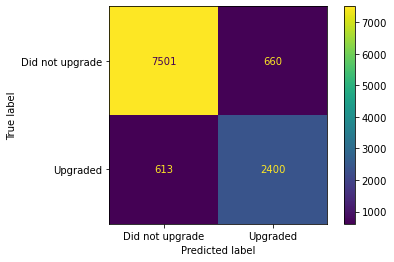

In [220]:
pca_to_SVM(X3, y, 10)

(44694, 15)
(11174, 15)
Your f1 score is 0.8044729485282027


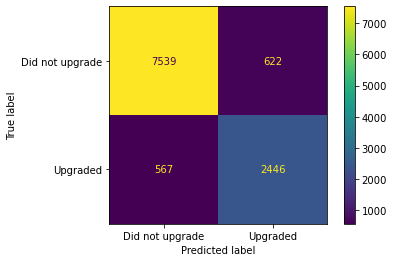

In [221]:
model_SVM(X_encoded, y)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size = 0.80, random_state = 12)

scaler = StandardScaler()

scaler.fit(X_train)

scaler.fit(X_test)

X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [95]:
X_train_scaled.shape

(44694, 15)

In [96]:
X_test_scaled.shape

(11174, 15)

In [97]:
trac_SVM = SVC(C = 100, gamma = 0.1, kernel = 'rbf',random_state = 12)

trac_SVM.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.1, random_state=12)

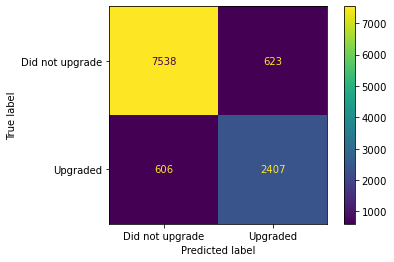

In [98]:
plot_confusion_matrix(trac_SVM,
                     X_test_scaled,
                     y_test,
                     display_labels = ["Did not upgrade","Upgraded"])

In [99]:
y_pred=trac_SVM.predict(X_test_scaled)
f1_score(y_test, y_pred)

0.7966241932814827

## Recursive Feature Elimination con Random Forest

What this does is run the model with all the available features and gives you a score of the importance of each one. Then remove the less important ones and do the same exercise again. We choose the number of subsets of the features we want to test and the size of the subset. So the subset is the hyperparameter to tune here. The subset that optimizes the criteria we are looking for is then used to train the model.

In [87]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV #Library de RFE with cross-val
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [58]:
X_reduce_encoded.head()

,upgrade,touch_screen,wi_fi,year_released,activation_to_observed,redemption_to_observed,released_to_observed,redemption_count,mean_revenue,deactivations_count,...,gsma_operating_system_OTHER,gsma_operating_system_iOS,total_ram_1024,total_ram_1536,total_ram_2048,total_ram_3072,total_ram_4096,total_ram_512,total_ram_6144,total_ram_OTHER
1,1,1,1,2018,699.0,20.0,3,25.0,50.728800,3.0,...,0,1,0,0,0,1,0,0,0,0
2,0,1,1,2016,175.0,20.0,5,6.0,35.000000,4.0,...,0,1,0,0,1,0,0,0,0,0
4,1,1,1,2018,191.0,20.0,3,6.0,54.000000,1.0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,2018,65.0,25.0,3,3.0,20.000000,1.0,...,0,0,0,0,0,0,0,0,0,1
6,0,1,1,2016,206.0,84.0,5,9.0,21.913333,2.0,...,0,1,0,0,1,0,0,0,0,0


First we have to look for correlations within our features so as not to be redundant. Obviously excluding the target

In [59]:
correlated_features = set()
correlation_matrix = X_reduce_encoded.drop('upgrade', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [60]:
correlated_features 

{'carrier_carrier 1',
 'gsma_operating_system_iOS',
 'redemption_count',
 'released_to_observed',
 'total_ram_OTHER',
 'wi_fi'}

In [62]:
## We drop redemption_count because it has more than 0.8 of corr with another

X_reduce_encoded.drop(['redemption_count', 'carrier_carrier 1', 'gsma_operating_system_iOS',
                      'released_to_observed', 'total_ram_OTHER', 'wi_fi'], axis = 1, inplace = True)

In [63]:
y_reduce = X_reduce["upgrade"].copy()

X_reduce_encoded.drop("upgrade", axis = 1, inplace = True)

print(y_reduce.shape)
print(X_reduce_encoded.shape)


(42825,)
(42825, 27)


In [67]:
scaler = StandardScaler()

scaler.fit(X_reduce_encoded)

X_train_scaled = scaler.transform(X_reduce_encoded)

Feature selection with cross-val and relevant metric f1 score

In [82]:
rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='f1')
rfecv.fit(X_reduce_encoded, y_reduce)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=101), scoring='f1')

In [83]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 24


In [92]:

print(np.where(rfecv.support_ == False)[0])

X_reduce_encoded.drop(X_reduce_encoded.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[19 21 25]


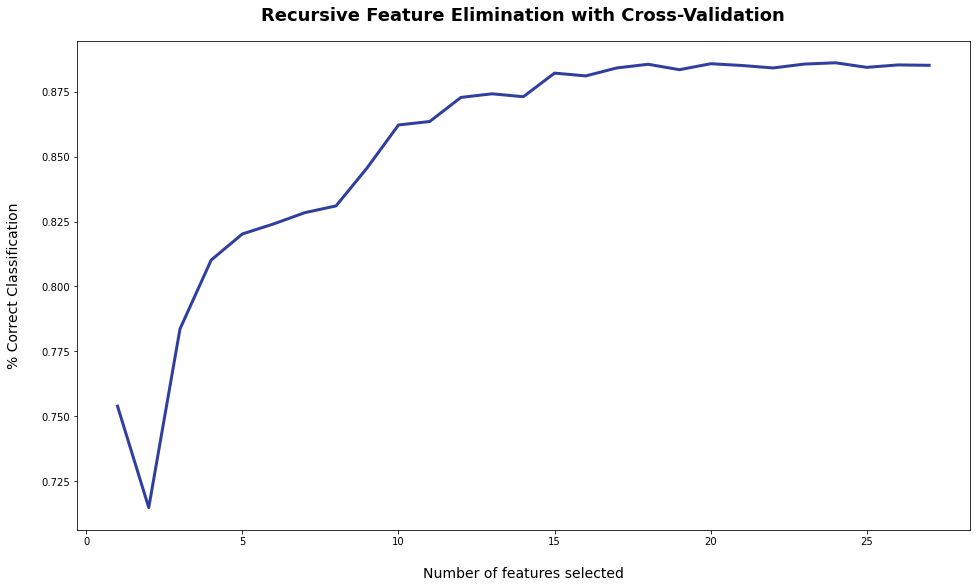

In [93]:

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

#### From the above we can see that from 15 features the changes in correct classification are very small, so getting more variables will just increase noise.

In [94]:
rfecv.estimator_.feature_importances_.shape

(24,)

In [95]:
X_reduce_encoded.columns.shape

(24,)

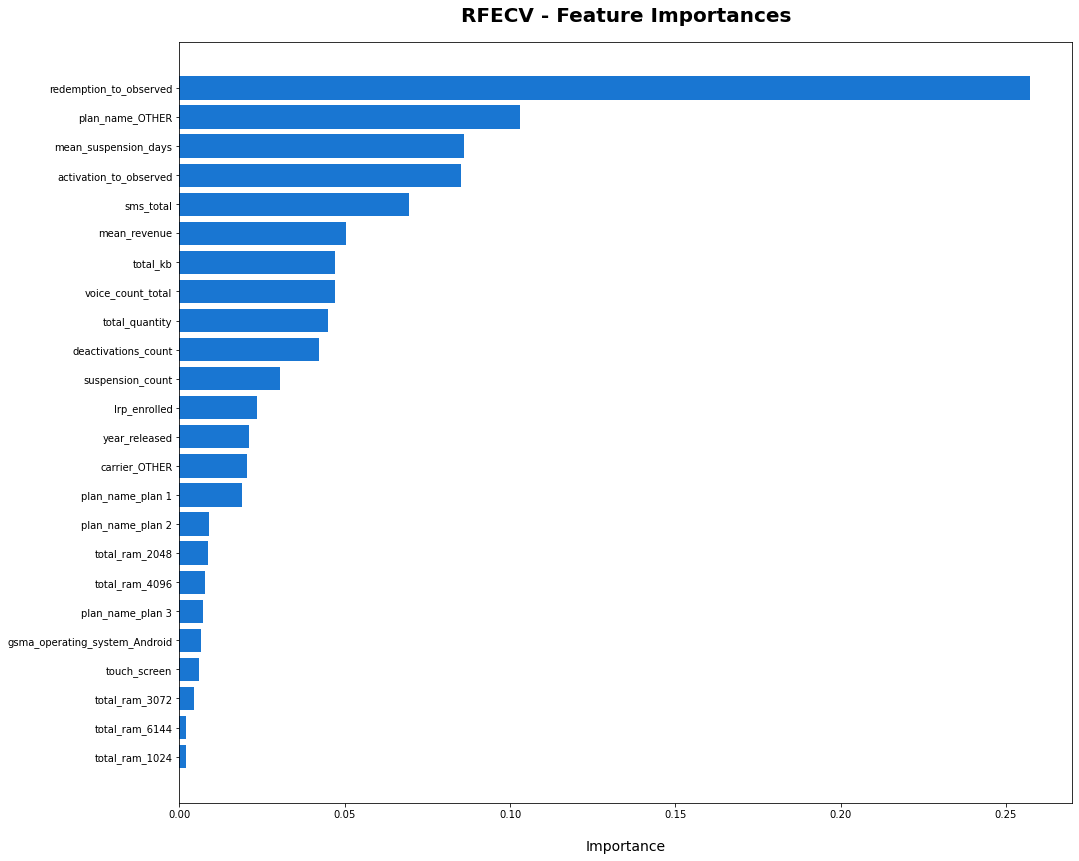

In [97]:
dset = pd.DataFrame()
dset['attr'] = X_reduce_encoded.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=True)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

Least important features

In [ ]:
print(np.where(rfecv.support_ == False)[0])


In [ ]:
# To drop them:

X_reduce_encoded.drop(X_reduce_encoded.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

This notebook functions as a support for the mlcode-datathon notebook. Here various models were tested and it was concluded that a more general model as SVM gave us the better performance.

Three keypoints:

+ **RandomForest** = random forest performance in training was amazing, giving 0.88 f1_scores. But it has a tendency for overfitting, and the first evaluation we had came back with a real 0.62 f1_score. So we began in the look for XGBoost and SVM alternatives. But since SVM was less complex we decided to use it instead of XGBoost.
+ **SVM** = The SVM, for its nature, will cluster our data, then by tunning C and gamma parameters I was able to improve our perfomance quite a lot. We went from 0.62 to 0.80 using a SVM. C was given a big value of 100 so that it could generalize more, and gamma was scaled so that our model didn't track exactly the errors in our data, to prevent overfitting.
+ **Deep Learning** = for this type of cases you could use a NN to increase the accuracy and other metrics quite a lot, but for this challenge my team was only permitted to use ML.